# SDFusion: Text-guided Generation (txt2shape)

### TODO: add sample results or teaser images

In [ ]:
!git clone https://github.com/ScheznikL/SDFusion.git
%cd SDFusion
!ls

Cloning into 'SDFusion'...
remote: Enumerating objects: 1979, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 1979 (delta 54), reused 81 (delta 34), pack-reused 1859 (from 1)
Receiving objects: 100% (1979/1979), 35.93 MiB | 16.85 MiB/s, done.
Resolving deltas: 100% (815/815), done.
Updating files: 100% (2464/2464), done.
/content/SDFusion
configs		    demo_img2shape.ipynb	  external   options	   train.py
dataset_info_files  demo_mm2shape.ipynb		  launchers  preprocess    utils
datasets	    demo_txt2shape.ipynb	  LICENSE    README.md
demo_data	    demo_uncond_shape_comp.ipynb  models     setup_env.sh


In [ ]:
# first set up which gpu to use
import os
gpu_ids = 0
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_ids}"

In [ ]:
#exit()
#How to run a Python script in a '.py' file from a Google Colab notebook?
from models.base_model import create_model

In [ ]:
!pip install h5py joblib trimesh scipy PyMCubes
#pip install --upgrade PyMCubes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.8/704.8 kB 13.5 MB/s eta 0:00:00


In [ ]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("2.1.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-qso0hpec
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-qso0hpec
  Running command git checkout -q 75ebeeaea0908c5527e7b1e305fbc7681382db47
  Resolved https://github.com/facebookresearch/pytorch3d.git to commit 75ebeeaea0908c5527e7b1e305fbc7681382db47
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch3d: filename=pytorch3d-0.7.8-cp310-cp310-linux_x86_64.whl size=59599692 sha256=f4afb6d61ec1de81de44dd730ca5a4fd020653263898aceb98e5c9a4ad4d1402
  Stored in directory: /tmp/pip-ephem-wheel-cache-38v17raa/wheels/39/5f/20/2d3b6f3a35a60bdc0ba3c19da94340db9596637d1d1222473d
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31528 sha256=bf5d44cc1c48d1022d2cb3c

In [ ]:
# import libraries
import numpy as np
from IPython.display import Image as ipy_image
from IPython.display import display
from termcolor import colored, cprint

import torch
import torch.backends.cudnn as cudnn
cudnn.benchmark = True
import torchvision.utils as vutils

from models.base_model import create_model
from utils.util_3d import render_sdf, render_mesh, sdf_to_mesh, save_mesh_as_gif

%load_ext autoreload
%autoreload 2

# New section

In [ ]:
!pip install omegaconf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.5 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144555 sha256=52b25fc8b661a705b0ff2330eaad3003637de85eecd6e725c040b676fa3130c0
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime


In [ ]:
# options for the model. please check `utils/demo_util.py` for more details
from utils.demo_util import SDFusionText2ShapeOpt

seed = 2023
opt = SDFusionText2ShapeOpt(gpu_ids=gpu_ids, seed=seed)
device = opt.device

[*] SDFusionText2ShapeOption initialized.


In [ ]:
!mkdir saved_ckpt

In [ ]:
# SDFusion: text-guided shape generation (txt2shape)
!wget https://uofi.box.com/shared/static/vyqs6aex3rwbgxweyl3qh21c8p6vu33f.pth -O saved_ckpt/sdfusion-txt2shape.pth
# VQVAE's checkpoint
!wget https://uofi.box.com/shared/static/zdb9pm9wmxaupzclc7m8gzluj20ja0b6.pth -O saved_ckpt/vqvae-snet-all.pth

--2025-01-06 01:40:00--  https://uofi.box.com/shared/static/vyqs6aex3rwbgxweyl3qh21c8p6vu33f.pth
Resolving uofi.box.com (uofi.box.com)... 74.112.186.157
Connecting to uofi.box.com (uofi.box.com)|74.112.186.157|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/vyqs6aex3rwbgxweyl3qh21c8p6vu33f.pth [following]
--2025-01-06 01:40:00--  https://uofi.box.com/public/static/vyqs6aex3rwbgxweyl3qh21c8p6vu33f.pth
Reusing existing connection to uofi.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://uofi.app.box.com/public/static/vyqs6aex3rwbgxweyl3qh21c8p6vu33f.pth [following]
--2025-01-06 01:40:00--  https://uofi.app.box.com/public/static/vyqs6aex3rwbgxweyl3qh21c8p6vu33f.pth
Resolving uofi.app.box.com (uofi.app.box.com)... 74.112.186.157
Connecting to uofi.app.box.com (uofi.app.box.com)|74.112.186.157|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcl

In [ ]:
# initialize SDFusion model
ckpt_path = 'saved_ckpt/sdfusion-txt2shape.pth'
opt.init_model_args(ckpt_path=ckpt_path)

SDFusion = create_model(opt)
cprint(f'[*] "{SDFusion.name()}" loaded.', 'cyan')

Working with z of shape (1, 3, 16, 16, 16) = 12288 dimensions.
[*] VQVAE: weight successfully load from: saved_ckpt/vqvae-snet-all.pth


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/content/SDFusion/models/sdfusion_txt2shape_model.py:567: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ckpt, map_location=map_fn)


[*] weight successfully load from: saved_ckpt/sdfusion-txt2shape.pth
[*] setting ddim_steps=100
[*] Model has been created: SDFusion-Text2Shape-Model
[*] "SDFusion-Text2Shape-Model" loaded.


## SDFusion: text-guided generation (txt2shape)

In [ ]:

# txt2shape
out_dir = 'demo_results'
if not os.path.exists(out_dir): os.makedirs(out_dir)

# change the input text here to generate different chairs/tables!
input_txt_old = "A round red color chair with four legs 0.5 meters in length each"
input_txt = "Generate a chair with four legs of 0.53 meters in length, a round seat cushion with a radius of 1/2 of leg length, and a slat back with gaps of 0.11 meters."

ngen = 1 # number of generated shapes
ddim_steps = 100
ddim_eta = 0.
uc_scale = 3.
# Log start time
start_time = datetime.now()
print(f"{start_time}: Starting txt2shape generation")

sdf_gen = SDFusion.txt2shape(input_txt=input_txt, ngen=ngen, ddim_steps=ddim_steps, ddim_eta=ddim_eta, uc_scale=uc_scale)

# Log after sdf_to_mesh generation
end_time = datetime.now()
print(f"{end_time}: Completed sdf_to_mesh")

mesh_gen = sdf_to_mesh(sdf_gen)

'''# Save meshes to .obj and/or .ply
for i, mesh in enumerate(mesh_gen):
    verts, faces = mesh.verts_packed(), mesh.faces_packed()
    # Save to .obj format
    obj_path = f"{out_dir}/shape_{i}_{input_txt.replace(' ', '_')}.obj"
    save_obj(obj_path, verts, faces)
    print(f"Saved OBJ to {obj_path}")'''

# vis as gif
#gen_name = f'{out_dir}/txt2shape-{input_txt}.gif'
#save_mesh_as_gif(SDFusion.renderer, mesh_gen, nrow=3, out_name=gen_name)

#print(f'Input: "{input_txt}"')
#for name in [gen_name]:
#    display(ipy_image(name))

Data shape for DDIM sampling is (1, 3, 16, 16, 16), eta 0.0
Running DDIM Sampling with 100 timesteps


DDIM Sampler: 100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


'# Save meshes to .obj and/or .ply\nfor i, mesh in enumerate(mesh_gen):\n    verts, faces = mesh.verts_packed(), mesh.faces_packed()\n    # Save to .obj format\n    obj_path = f"{out_dir}/shape_{i}_{input_txt.replace(\' \', \'_\')}.obj"\n    save_obj(obj_path, verts, faces)\n    print(f"Saved OBJ to {obj_path}")'

In [ ]:
#@title save Mesh
#from pytorch3d.io import save_mesh
from pathlib import Path
from pytorch3d.io import IO

for i, mesh in enumerate(mesh_gen):
  #mesh.textures.faces_verts_textures_packed()

    mesh_path = Path(out_dir) / f"NEWshape_{i}_{input_txt.replace(' ', '_')}.ply"
    IO().save_mesh(mesh, mesh_path,include_textures=True) #binary=False, colors_as_uint8=True

# Directory for saving meshes
#out_dir = 'demo_results'
#Path(out_dir).mkdir(parents=True, exist_ok=True)

# Iterate through generated meshes and save each one
'''for i, mesh in enumerate(mesh_gen):
    # Ensure the mesh has only one element
    #mesh = mesh.extend(1)  # Create a single-element Meshes object

    # Define the output path


    # Save the mesh with textures included
    save_mesh(mesh, mesh_path, binary=True, include_textures=True)
    print(f"Saved mesh to {mesh_path}")'''

'for i, mesh in enumerate(mesh_gen):\n    # Ensure the mesh has only one element\n    #mesh = mesh.extend(1)  # Create a single-element Meshes object\n\n    # Define the output path\n    \n\n    # Save the mesh with textures included\n    save_mesh(mesh, mesh_path, binary=True, include_textures=True)\n    print(f"Saved mesh to {mesh_path}")'

In [ ]:
import os
import torch
import matplotlib.pyplot as plt
'''
# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    DirectionalLights,
    Materials,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    TexturesUV,
    TexturesVertex
)
'''


'\n# Util function for loading meshes\nfrom pytorch3d.io import load_objs_as_meshes, load_obj\n\n# Data structures and functions for rendering\nfrom pytorch3d.structures import Meshes\nfrom pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene\nfrom pytorch3d.vis.texture_vis import texturesuv_image_matplotlib\nfrom pytorch3d.renderer import (\n    look_at_view_transform,\n    FoVPerspectiveCameras, \n    PointLights, \n    DirectionalLights, \n    Materials, \n    RasterizationSettings, \n    MeshRenderer, \n    MeshRasterizer,  \n    SoftPhongShader,\n    TexturesUV,\n    TexturesVertex\n)\n'

In [ ]:
'''!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid'''

--2025-01-06 00:25:21--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608 (1.6K) [text/plain]
Saving to: ‘plot_image_grid.py’

plot_image_grid.py  100%[===================>]   1.57K  --.-KB/s    in 0s      

2025-01-06 00:25:21 (29.3 MB/s) - ‘plot_image_grid.py’ saved [1608/1608]



In [ ]:
'''from pytorch3d.io import save_ply

verts = mesh_gen.verts_packed()
faces = mesh_gen.faces_packed()
verts_rgb = mesh_gen.textures.verts_features_packed()

# Save to PLY
ply_path = Path(out_dir) / "textured_mesh.ply"
save_ply(ply_path, verts, faces)
print(f"Saved PLY with vertex colors to {ply_path}")'''

NameError: name 'Path' is not defined

## display render

TEXTURES ---- <pytorch3d.renderer.mesh.textures.TexturesVertex object at 0x7a033c7674f0>---


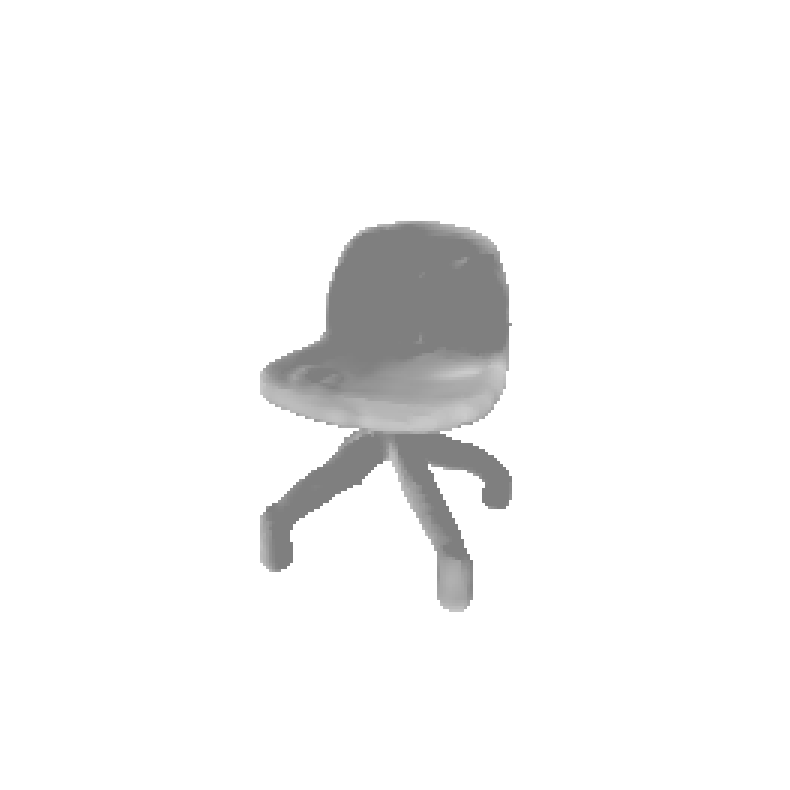

In [ ]:
#images = SDFusion.renderer(mesh)
#mesh.textures.faces_verts_textures_packed()
from pytorch3d.renderer import PointLights

lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])
lights.location = torch.tensor([0.2, 0.0, 0.0], device=device)[None]

for i, mesh in enumerate(mesh_gen):
    texture_image = mesh.textures.verts_features_padded().squeeze().cpu().numpy()
    img_comb = SDFusion.renderer(mesh, lights=lights)
    print(f"TEXTURES ---- {mesh.textures}---")
    #img_comb = render_mesh(SDFusion.renderer, mesh, norm=False)
    plt.figure(figsize=(10, 10))
    plt.imshow(img_comb[0, ..., :3].cpu().numpy())
   # plt.imshow(img_comb.cpu().numpy())
    plt.axis("off")

Texture shape: torch.Size([1, 8086, 3])


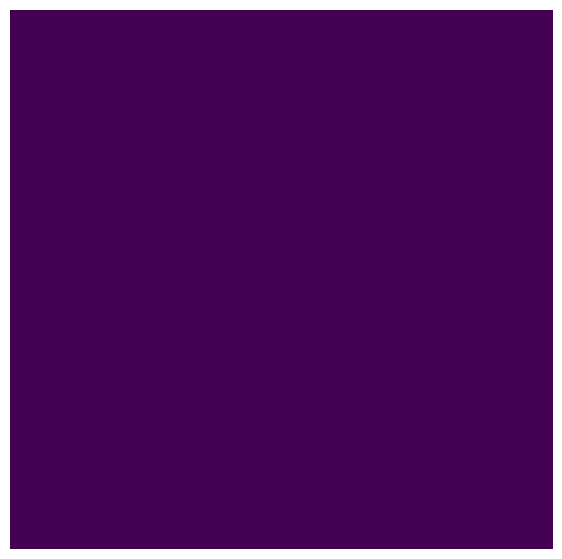

In [ ]:
'''for i, mesh in enumerate(mesh_gen):
  plt.figure(figsize=(7,7))
  texture_image=mesh.textures.verts_features_padded()
  plt.imshow(texture_image.squeeze().cpu().numpy())
  plt.axis("off");'''
for i, mesh in enumerate(mesh_gen):
    plt.figure(figsize=(7, 7))

    # Get vertex features (e.g., RGB values)
    texture_image = mesh.textures.verts_features_padded()  # Shape: (1, N, 3)

    # Check the shape of the texture
    print(f"Texture shape: {texture_image.shape}")

    # Visualize the texture as an array (flattening may be needed)
    texture_image_np = texture_image.squeeze().cpu().numpy()  # Shape: (N, 3)
    plt.imshow(texture_image_np, aspect='auto')  # Display as a continuous line
    plt.axis("off")

In [ ]:
import trimesh
import numpy as np

# Extract vertex positions, faces, and vertex colors
verts = mesh.verts_packed().cpu().numpy()  # (N, 3)
faces = mesh.faces_packed().cpu().numpy()  # (F, 3)
verts_rgb = mesh.textures.verts_features_packed().cpu().numpy()  # (N, 3)

# Create a Trimesh object with vertex colors
trimesh_mesh = trimesh.Trimesh(vertices=verts, faces=faces, vertex_colors=verts_rgb)#vertex_colors=(verts_rgb * 255).astype(np.uint8)

# Save to .ply
ply_path = Path(out_dir) / f"newshape_{i}_{input_txt.replace(' ', '_')}.ply"
trimesh_mesh.export(ply_path)
print(f"Saved mesh with vertex colors to {ply_path}")


Saved mesh with vertex colors to demo_results/newshape_0_A_round_red_color_chair_with_four_legs_0.5_meters_in_length_each.ply


In [ ]:
from pytorch3d.io import save_obj, save_ply

 # Assuming each mesh has a `textures` attribute with a Textures object
for i, mesh in enumerate(mesh_gen):
    verts, faces = mesh.verts_packed(), mesh.faces_packed()

    # Save geometry and textures to .obj format
    if hasattr(mesh, 'textures') and mesh.textures is not None:
        vertex_colors = mesh.textures.verts_features_packed()  # Extract vertex colors

        # Save to .obj without UVs but with vertex colors
        obj_path = f"{out_dir}/shape_{i}_{input_txt.replace(' ', '_')}_textured.obj"
        save_obj(obj_path, verts, faces)  # OBJ doesn't natively support vertex colors
        print(f"Saved OBJ to {obj_path} (vertex colors not directly supported in OBJ)")

        # Save to .ply with vertex colors
        ply_path = f"{out_dir}/shape_{i}_{input_txt.replace(' ', '_')}_textured.ply"
        save_ply(ply_path, verts, faces, verts_rgb=vertex_colors)
        print(f"Saved PLY to {ply_path} (with vertex colors)")

    else:
        # Save without textures
        obj_path = f"{out_dir}/shape_{i}_{input_txt.replace(' ', '_')}.obj"
        save_obj(obj_path, verts, faces)
        print(f"Saved OBJ (no textures) to {obj_path}")


Saved OBJ to demo_results/shape_0_A_round_red_color_chair_with_four_legs_0.5_meters_in_length_each_textured.obj (vertex colors not directly supported in OBJ)


TypeError: save_ply() got an unexpected keyword argument 'verts_rgb'